In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [141]:
import os
import numpy as np
import pandas as pd
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet,  preprocess_input
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import model_from_json
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


**Part 1. 1 a - Import and read ‘images.npy’**

In [ ]:
data = np.load('/content/drive/MyDrive/Greatlearning/ComputerVsion Project/Images.npy', allow_pickle=True)

In [ ]:
data.shape

(393, 2)

In [ ]:
data[2][0]

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[ 80,  31,  18, 255],
        [ 82,  36,  23, 255],
        [ 79,  31,  21, 255],
        ...,
        [121, 114, 104, 255],
        [120, 112, 104, 255],
        [116, 109,  99, 255]],

       [[ 73,  38,  20, 255],
        [ 76,  40,  24, 255],
        [ 79,  45,  30, 255],
        ...,
        [121, 112, 104, 255],
        [117, 110, 102, 255],
        [113, 106,  97, 255]],

       [[ 79

In [ ]:
data[2][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.495, 'y': 0.27147766323024053},
   {'x': 0.595, 'y': 0.46048109965635736}],
  'imageWidth': 600,
  'imageHeight': 291}]

**Part 1.1 b - Split the data into Features(X) &
labels(Y). Unify shape of all the images.**

In [ ]:
ALPHA = 1

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

IMAGE_SIZE = 224

In [ ]:
#create masked image and preprocessed image (to feed mobile Net)
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
y = np.zeros((int(data.shape[0]), IMAGE_WIDTH, IMAGE_HEIGHT))
for index in range(data.shape[0]):


    # img = cv2.resize(data[index][0], dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    # img = data[index][0].resize((IMAGE_SIZE, IMAGE_SIZE,3))
    img = data[index][0]
    # print(img.shape[2])
    if len(img.shape) >= 3:
      img = img[:, :, :3]

    # print(img.shape)
    num_channels = 1 if len(img.shape) == 2 else img.shape[-1]
    if num_channels == 1:
      # print("---")
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # print(1 if len(img.shape) == 2 else img.shape[-1])
    img = cv2.resize(img, (224, 224))
    X[index] = preprocess_input(np.array(img, dtype=np.float32))


    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        y[index][y1:y2, x1:x2] = 1








**Part 1.1 c - Split the data into train and test
[400:9].**

In [ ]:
train_size = 400 / (400 + 9) # (mentioned train : test is 400 : 9)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)


In [ ]:
print("X train : ({},{})".format(len(X_train),len(X_train[0][0])))
print("y train : ({},{})".format(len(y_train),len(y_train[0])))
print("X test : ({},{})".format(len(X_test),1))
print("y test : ({},{})".format(len(y_test),len(y_test[0])))
# pd.DataFrame(X_train)


X train : (384,224)
y train : (384,224)
X test : (9,1)
y test : (9,224)


In [ ]:
len(X_train[0])

224

In [ ]:
print(X_train[0])

[[[-0.78823531 -0.83529413 -0.81960785]
  [-0.79607844 -0.85882354 -0.82745099]
  [-0.78823531 -0.85882354 -0.81960785]
  ...
  [-0.92941177 -0.97647059 -0.96078432]
  [-0.92941177 -0.97647059 -0.96078432]
  [-0.92941177 -0.97647059 -0.96078432]]

 [[-0.63137257 -0.7019608  -0.67843139]
  [-0.63921571 -0.71764708 -0.68627453]
  [-0.63137257 -0.71764708 -0.68627453]
  ...
  [-0.9137255  -0.96078432 -0.92941177]
  [-0.9137255  -0.96078432 -0.92941177]
  [-0.9137255  -0.96078432 -0.92941177]]

 [[-0.62352943 -0.71764708 -0.68627453]
  [-0.63137257 -0.72549021 -0.69411767]
  [-0.65490198 -0.74901962 -0.72549021]
  ...
  [-0.87450981 -0.95294118 -0.89803922]
  [-0.87450981 -0.95294118 -0.89803922]
  [-0.87450981 -0.95294118 -0.89803922]]

 ...

 [[-0.81176472 -0.85882354 -0.8509804 ]
  [-0.83529413 -0.84313726 -0.83529413]
  [-0.80392158 -0.81176472 -0.80392158]
  ...
  [-0.89803922 -0.99215686 -0.9137255 ]
  [-0.89803922 -0.99215686 -0.9137255 ]
  [-0.89803922 -0.99215686 -0.9137255 ]]

 [

In [ ]:
print(np.array(X_train).shape)

(384, 224, 224, 3)


In [ ]:
print(np.array(y_train).shape)

(384, 224, 224)


In [ ]:
print()

**Part 1.1 d - Select random image from the train data and
display original image and masked image.**

Image array:


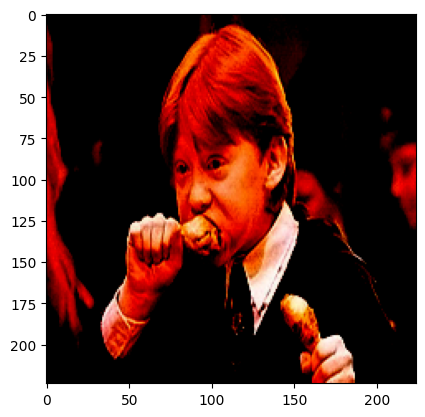

In [ ]:
print("Image array:")
plt.imshow(X_train[20])

Mased array:


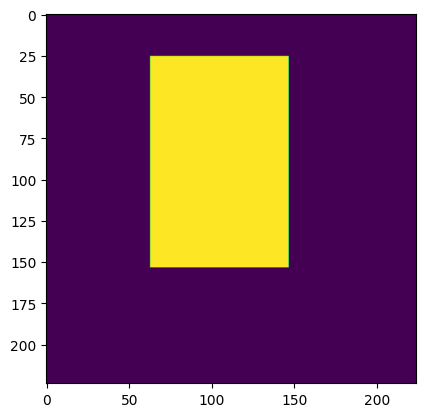

In [ ]:
print("Mased array:")
plt.imshow(y_train[20])

**Part 1.2 a - Design a face mask detection model.**

In [ ]:


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = UpSampling2D(size=(8, 8))(x)  # Upsample by 8x8 to match the desired output shape

    return Model(inputs=model.input, outputs=x)





**B. Design your own Dice Coefficient and Loss function. [2 Marks]**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())


**C. Train and tune the model as required. [3 Marks]**

In [ ]:
model = create_model(False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']      

In [ ]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

In [ ]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
tensorflow.keras.backend.clear_session()
tensorflow.config.run_functions_eagerly(True)
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50, batch_size=1,callbacks=[checkpoint, reduce_lr, stop])


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
384/384 [==============================] - ETA: 0s - loss: 1.1251 - dice_coefficient: 0.4877
Epoch 1: val_loss improved from inf to 1.14322, saving model to model-1.14.h5
384/384 [==============================] - 50s 130ms/step - loss: 1.1251 - dice_coefficient: 0.4877 - val_loss: 1.1432 - val_dice_coefficient: 0.4809 - lr: 0.0010
Epoch 2/50
384/384 [==============================] - ETA: 0s - loss: 0.8327 - dice_coefficient: 0.5844
Epoch 2: val_loss improved from 1.14322 to 1.10039, saving model to model-1.10.h5
384/384 [==============================] - 49s 127ms/step - loss: 0.8327 - dice_coefficient: 0.5844 - val_loss: 1.1004 - val_dice_coefficient: 0.5024 - lr: 0.0010
Epoch 3/50
384/384 [==============================] - ETA: 0s - loss: 0.7817 - dice_coefficient: 0.6018
Epoch 3: val_loss improved from 1.10039 to 1.06535, saving model to model-1.07.h5
384/384 [==============================] - 50s 129ms/step - loss: 0.7817 - dice_coefficient: 0.6018 - val_loss: 1.0654 -

**Part 1.2 d - Evaluate and share insights on
performance of the model.**

Test image:


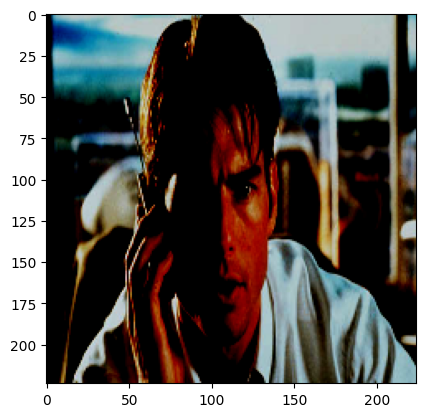

In [ ]:
print("Test image:")
plt.imshow(X_test[2])

Test masked image


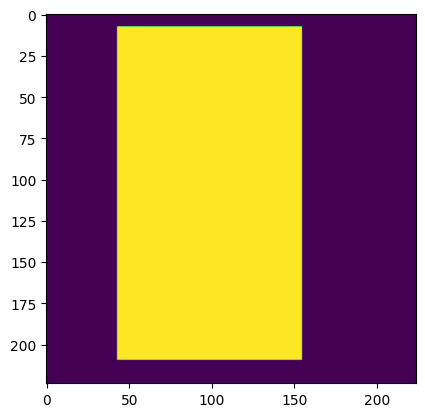

In [ ]:
print("Test masked image")
plt.imshow(y_test[2])

1/1 [==============================] - 0s 98ms/step


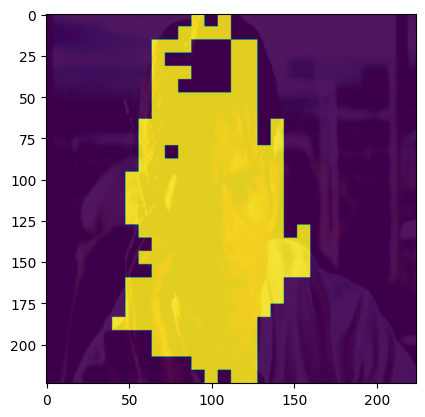

In [ ]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[2]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(X_test[2])
plt.imshow(pred_mask, alpha=0.9)


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 73ms/step


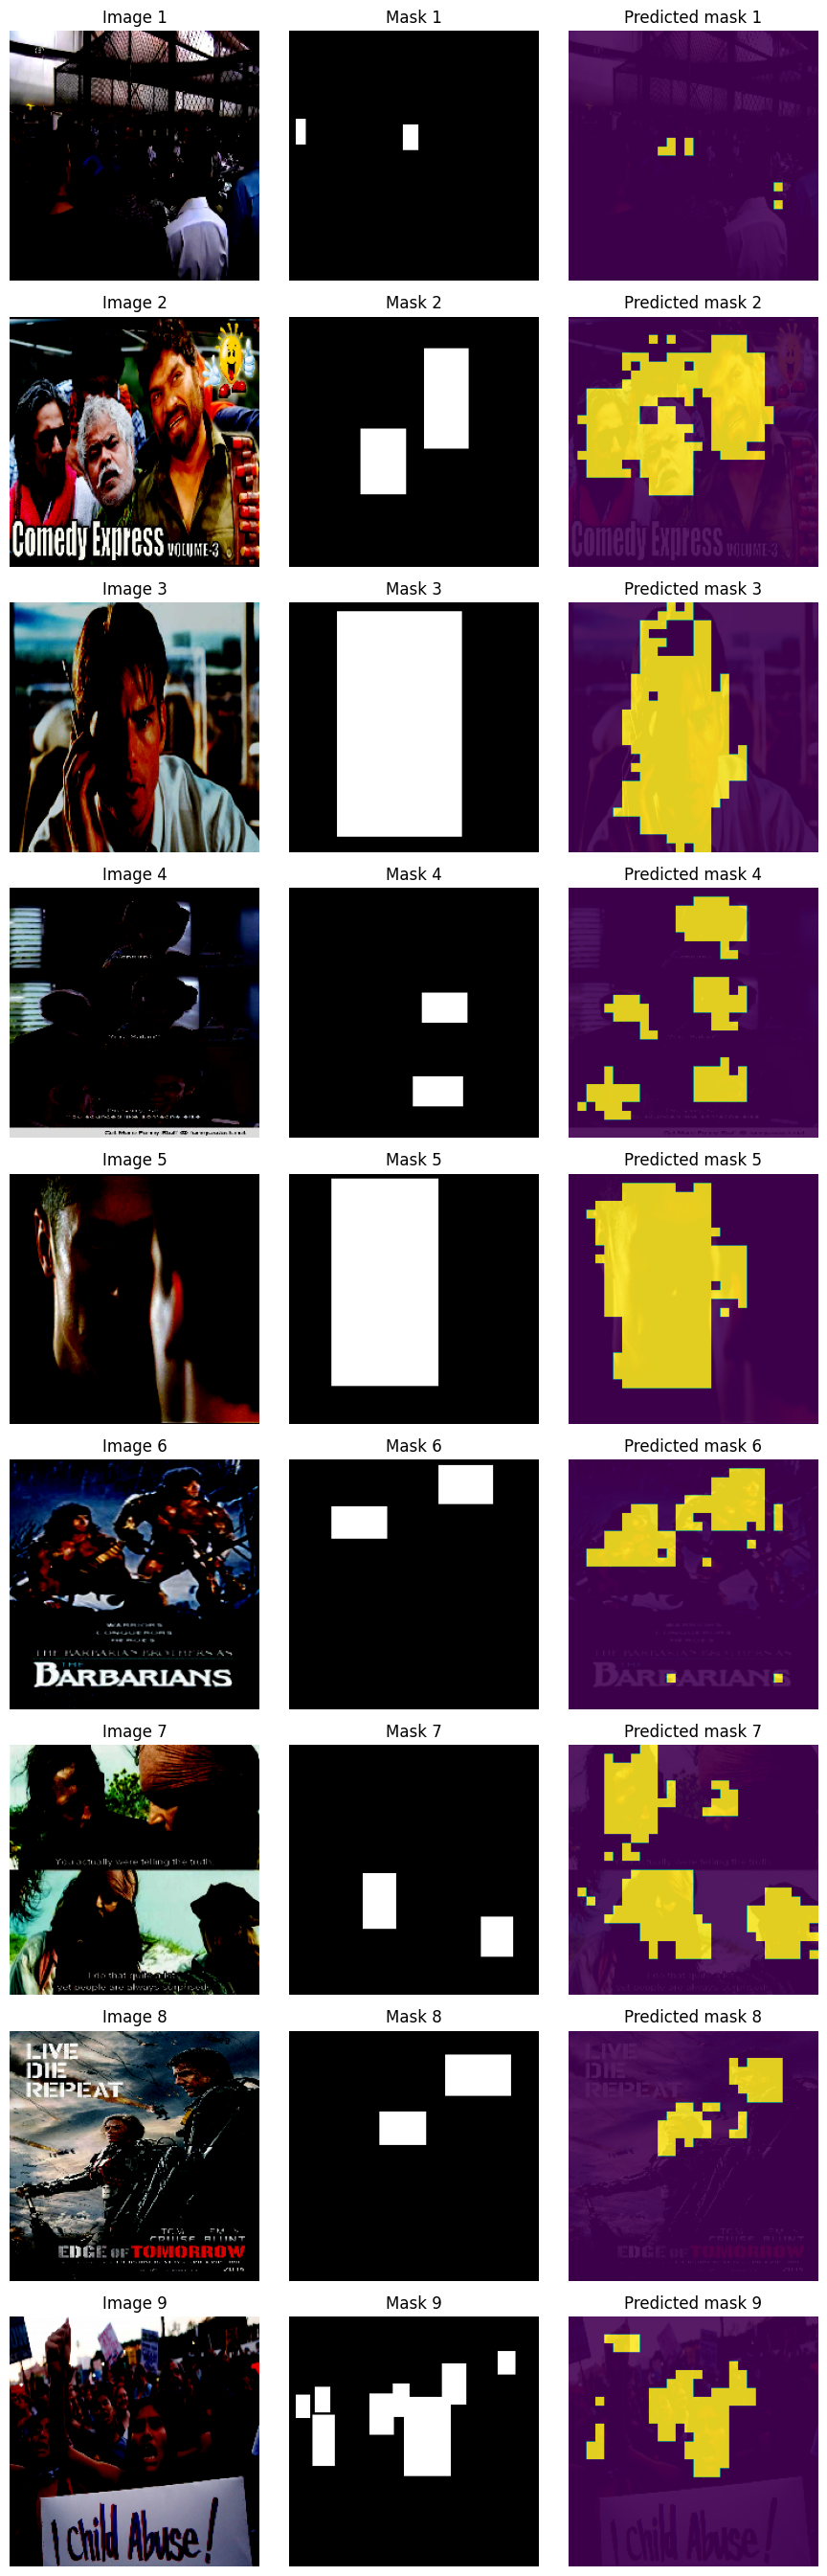

In [ ]:
# Parameters
num_samples = len(X_test)
num_columns = 3
image_scale = 3
num_rows = np.ceil(num_samples / (num_columns // 3)).astype(int)

# Create the figure
plt.figure(figsize=(image_scale * num_columns, image_scale * num_rows))

for i in range(num_samples):
    row = i // (num_columns // 3)
    col = i % (num_columns // 3) * 3

    plt.subplot(num_rows, num_columns, col + 1 + row * num_columns)
    plt.imshow(X_test[i])
    plt.title(f"Image {i + 1}")
    plt.axis('off')

    plt.subplot(num_rows, num_columns, col + 2 + row * num_columns)
    plt.imshow(y_test[i], cmap='gray')
    plt.title(f"Mask {i + 1}")
    plt.axis('off')

    pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[i]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))
    plt.subplot(num_rows, num_columns, col + 3 + row * num_columns)
    plt.imshow(X_test[i])
    plt.imshow(pred_mask, alpha=0.9)
    plt.title(f"Predicted mask {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Insights**

The prediction was very good, most of the faces was predicted and segmented/masked in the predicted image
Used early stopping to overcome overfitting, save resources etc..

**dice_coefficient: 0.6436**

**val_dice_coefficient: 0.5191**

Variations in the training process's loss and dice coefficient performance point to possible problems with convergence and model stability. Though there are significant swings, the validation loss appears to be steadily declining over epochs, suggesting improvement.







**Part 1.3 - Test the model predictions on the test
image: ‘image with index 3 in the test data’ and
visualise the predicted masks on the faces in the
image.**

Test image: (indx 3)


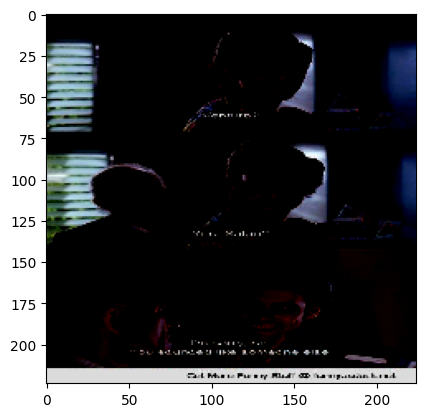

In [ ]:
print("Test image: (indx 3)")
plt.imshow(X_test[3])

Test masked image: (indx 3)


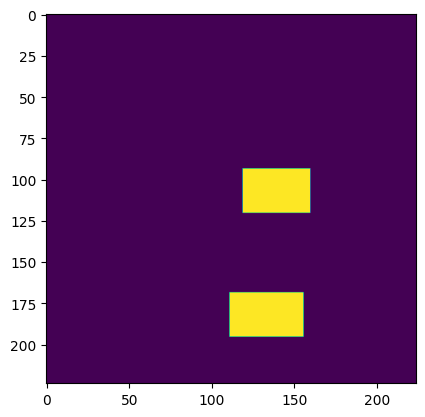

In [ ]:
print("Test masked image: (indx 3)")
plt.imshow(y_test[3])

1/1 [==============================] - 0s 71ms/step


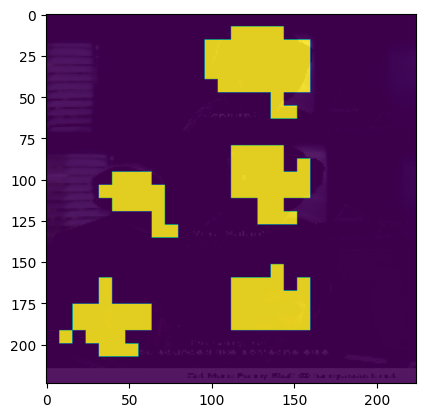

In [ ]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[3]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(X_test[3])
plt.imshow(pred_mask, alpha=0.9)

**Part 2.1 a Read/import images from folder
‘training_images’.**

In [ ]:
folder_path = '/content/drive/MyDrive/Greatlearning/ComputerVsion Project/training_images'

images = []
filenames = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        images.append(img)
        filenames.append(filename)


array([[[197, 199, 207],
        [197, 200, 205],
        [198, 198, 204],
        ...,
        [220, 216, 221],
        [220, 216, 221],
        [220, 216, 221]],

       [[201, 201, 207],
        [198, 198, 204],
        [197, 197, 203],
        ...,
        [220, 216, 221],
        [220, 216, 221],
        [220, 216, 221]],

       [[204, 202, 208],
        [200, 198, 204],
        [199, 197, 203],
        ...,
        [220, 216, 221],
        [220, 216, 221],
        [220, 216, 221]],

       ...,

       [[216, 215, 219],
        [216, 215, 219],
        [217, 216, 220],
        ...,
        [141, 235, 248],
        [141, 235, 248],
        [141, 235, 248]],

       [[216, 215, 219],
        [216, 215, 219],
        [216, 215, 219],
        ...,
        [141, 235, 248],
        [141, 235, 248],
        [141, 235, 248]],

       [[215, 214, 218],
        [215, 214, 218],
        [216, 215, 219],
        ...,
        [141, 235, 248],
        [141, 235, 248],
        [141, 235, 248]]], dtype=uint8)
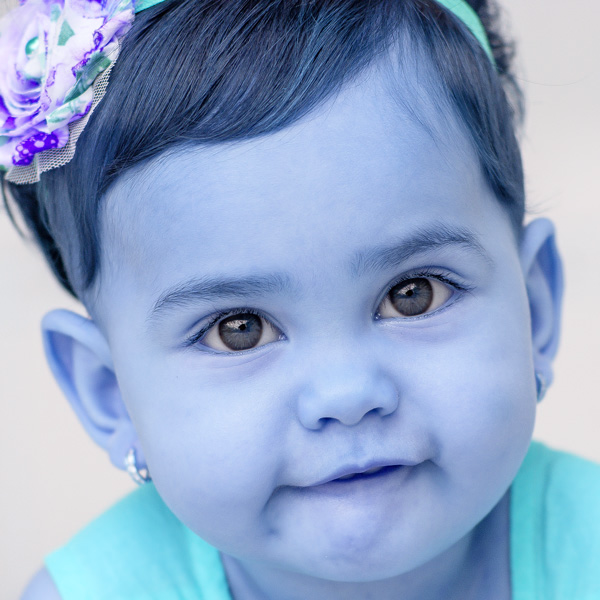

In [ ]:
images[0]

In [ ]:
filenames[0]

'real_00088.jpg'

**Part 2.1 b - Write a loop which will iterate
through all the images in the
‘training_images’ folder and detect the
faces present on all the images.**

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

face_metadata = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in faces:
            face_metadata.append({ 'x': x, 'y': y, 'width': w, 'height': h , 'Total_Faces' : len(faces),'Image_Name': filename,})

print("Face detection completed")


Face detection completed


**Part 2.1 c - From the same loop above, extract
metadata of the faces and write into a DataFrame.**

In [ ]:
df = pd.DataFrame(face_metadata)
df.head()

x    y  width  height  Total_Faces      Image_Name
0  108  129    447     447            1  real_00088.jpg
1  126  241    343     343            1  real_00083.jpg
2   67   56    461     461            1  real_00076.jpg
3   40  138    408     408            1  real_00079.jpg
4  131  129    438     438            1  real_00080.jpg

Already extracted the metadata of faces in the same loop for the above qn

**Part 2.1 d - Save the output Dataframe in .csv
format..**

In [ ]:
df.to_csv('face_metadata.csv', index=False)

**Part 2.1 a - Unzip, read and Load data(‘PINS.zip’)
into session.**

In [ ]:
zip_file_path = '/content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS.zip'

extract_dir = '/content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
print("Files extracted successfully:", extracted_files)


Files extracted successfully: ['PINS', '__MACOSX']


**Part 2.1 b - Write function to create
metadata of the image.**

In [4]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

**Part 2.1 c - Write a loop to iterate through each and
every image and create metadata for all the
images.**

In [37]:
metadata = load_metadata('/content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS/PINS')

In [6]:
print(metadata)

[/content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS/PINS/pins_mark zuckerberg/mark zuckerberg1.jpg
 /content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS/PINS/pins_mark zuckerberg/mark zuckerberg50.jpg
 /content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS/PINS/pins_mark zuckerberg/mark zuckerberg44.jpg
 ...
 /content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS/PINS/pins_Melissa benoit/Melissa benoit45.jpg
 /content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS/PINS/pins_Melissa benoit/Melissa benoit53.jpg
 /content/drive/MyDrive/Greatlearning/ComputerVsion Project/PINS/PINS/pins_Melissa benoit/Melissa benoit47.jpg]


In [7]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

array([[[67, 56, 50],
        [62, 51, 45],
        [56, 45, 39],
        ...,
        [22, 19, 12],
        [22, 19, 12],
        [23, 18, 12]],

       [[65, 54, 48],
        [64, 53, 47],
        [56, 45, 39],
        ...,
        [22, 19, 12],
        [22, 19, 12],
        [23, 18, 12]],

       [[61, 50, 46],
        [59, 48, 44],
        [47, 36, 30],
        ...,
        [23, 18, 12],
        [23, 18, 12],
        [23, 18, 12]],

       ...,

       [[60, 40, 41],
        [60, 40, 41],
        [56, 36, 37],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]],

       [[60, 40, 41],
        [60, 40, 41],
        [57, 37, 38],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]],

       [[61, 41, 42],
        [60, 40, 41],
        [57, 37, 38],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]]], dtype=uint8)
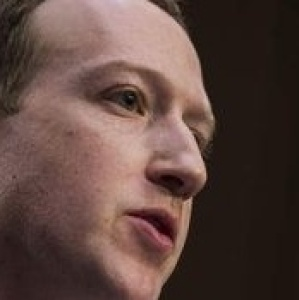

In [8]:
load_image(metadata[0].image_path())

**Part 2.1 d - Generate Embeddings vectors on the
each face in the dataset.**

In [9]:

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model


In [10]:
model = vgg_face()
model.load_weights('/content/drive/MyDrive/Greatlearning/ComputerVsion Project/vgg_face_weights.h5')

In [11]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [12]:

img_path = metadata[0].image_path()
img = load_image(img_path)

img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 3s 3s/step
(2622,)


In [13]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
      img = load_image(m.image_path())
      img = cv2.resize(img, dsize = (224,224))
      img = (img / 255.).astype(np.float32)
      embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step


**Part 2.1 e - Build distance metrics for identifying the
distance between two similar and dissimilar
images.**

In [14]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

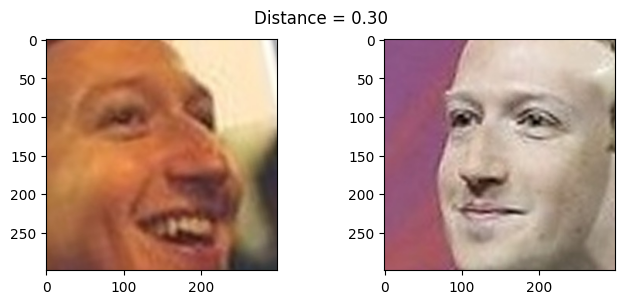

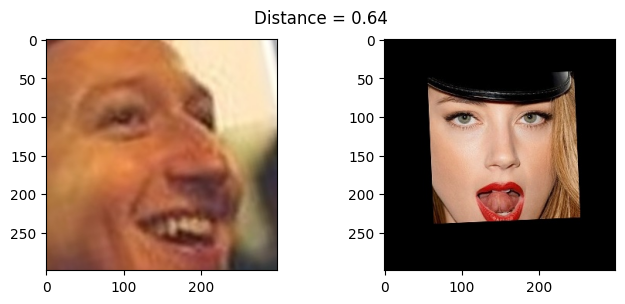

In [15]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(2, 180)

**Part 2.1 f - Use PCA for dimensionality reduction.**

In [60]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

Encoding

In [61]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

Scaling

In [62]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

PCA - dimensonality reduction

In [63]:
pca = PCA(n_components=128, svd_solver='randomized', whiten=True)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

**Part 2.1 g - Build an SVM classifier in order to map
each image to its right person.**

In [144]:
# clf = SVC(kernel='rbf', class_weight=None , C=10, gamma='auto')
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

clf = SVC()
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9679420889348499


SVC(C=1)

**Part 2.1 h - Import and display the the test images.**

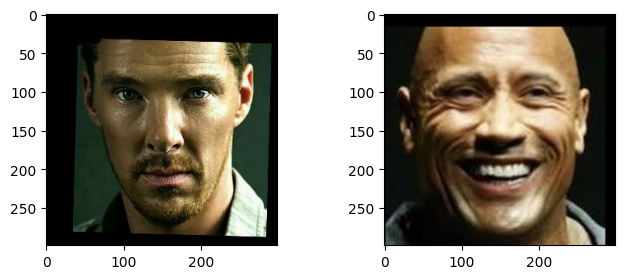

In [154]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(Image.open("/content/drive/MyDrive/Greatlearning/ComputerVsion Project/testing_images/Benedict Cumberbatch9.jpg"))
plt.subplot(122)
plt.imshow(Image.open("/content/drive/MyDrive/Greatlearning/ComputerVsion Project/testing_images/Dwayne Johnson4.jpg"))


**Part 2.1 i - Use the trained SVM model to predict the
face on both test images.**

In [155]:
test_image_directory = "/content/drive/MyDrive/Greatlearning/ComputerVsion Project/testing_images"

In [157]:
test_image_filenames = [f for f in os.listdir(test_image_directory) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

In [158]:
test_image_filenames

['Dwayne Johnson4.jpg', 'Benedict Cumberbatch9.jpg']

In [159]:
test_embeddings = np.zeros((len(test_image_filenames), 2622))
# test_embeddings = []

for i, filename in enumerate(test_image_filenames):
    image_path = os.path.join(test_image_directory, filename)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = (img / 255.).astype(np.float32)

    img_expanded = np.expand_dims(img, axis=0)
    test_embeddings[i] = vgg_face_descriptor.predict(img_expanded)[0]
    print(test_embeddings[i])

print(f"Extracted embeddings for {len(test_embeddings)} images with shape: {test_embeddings.shape}")

1/1 [==============================] - 0s 22ms/step
[ 0.01430988  0.00752764  0.0158792  ... -0.00922866  0.01744327
  0.00473036]
1/1 [==============================] - 0s 18ms/step
[ 0.0107411  -0.00820719  0.00615904 ... -0.00857323 -0.00022601
  0.0109814 ]
Extracted embeddings for 2 images with shape: (2, 2622)


In [160]:
test_embeddings = sc.transform(test_embeddings)
test_embeddings = pca.transform(test_embeddings)

Text(0.5, 1.0, 'Identified as pins_Chris Pratt')

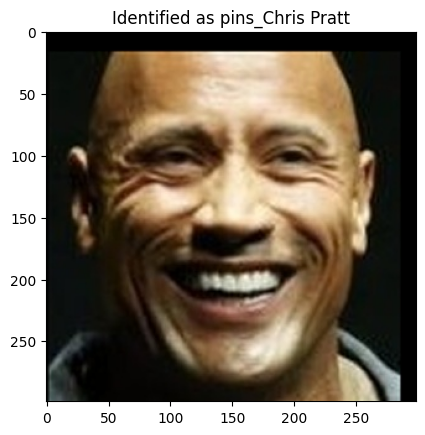

In [161]:
image = load_image(os.path.join(test_image_directory, "Dwayne Johnson4.jpg"))
prediction = best_clf.predict([test_embeddings[0]])
identity = encoder.inverse_transform(prediction)[0]

plt.imshow(image)
plt.title(f'Identified as {identity}')


[8]


Text(0.5, 1.0, 'Identified as pins_Chris Pratt')

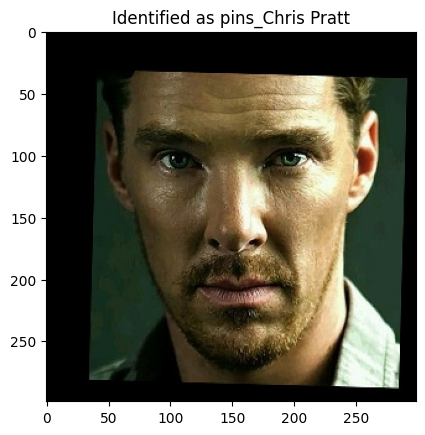

In [163]:
image = load_image(os.path.join(test_image_directory, "Benedict Cumberbatch9.jpg"))
prediction = best_clf.predict([test_embeddings[1]])
print(prediction)
identity = encoder.inverse_transform(prediction)[0]
plt.imshow(image)
plt.title(f'Identified as {identity}')